In [1]:
import os
import sys
import requests

sys.path.append(os.pardir)
import rsmine.coarsegrainer.build_dataset as ds
import rsmine.coarsegrainer.cg_optimisers as cg_opt
import rsmine.coarsegrainer.plotter as plotter

# RSMI optimisation for the dimer model

## Download sample dataset

In [2]:
url = 'https://polybox.ethz.ch/index.php/s/bUp9a5qZWuLGXMb/download'
filename = 'configs_intdimer2d_square_L64_T15.000.npy'
data_dir = os.path.join(os.pardir, 'data')

if os.path.isfile(os.path.join(data_dir, filename)):
    print('Existing dataset found.')
else:
    print('No existing dataset found.')
    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)
        print('Created the data directory.')
    print('Downloading data...')
    r = requests.get(url, allow_redirects=True)
    open(os.path.join(data_dir, filename), 'wb').write(r.content)
    print('Data downloaded into /coarsegrainer/data/.')

Existing dataset found.


## Enter system parameters

In [3]:
data_params = {
    'model': 'intdimer2d',
    'lattice_type': 'square',
    'L': 64,
    'T': 15.000,
    'N_samples': 28800, 
    'dimension': 2,
}

generator=ds.dataset(**data_params)

print(data_params)

Existing data found.
 Loading the data...
Loading complete.
{'model': 'intdimer2d', 'lattice_type': 'square', 'L': 64, 'T': 15.0, 'N_samples': 28800, 'dimension': 2}


## Enter optimisation parameters

In [4]:
CG_params = {'init_temperature': 0.75,
    'min_temperature': 0.1,
    'relaxation_rate': 0.0001, 
    'Nq': None,
    'conv_activation': None,
    'hidden_dim': 2,
    'h_embed': True,
    'use_probs': False,
    'use_logits': True
}
ll = CG_params['ll'] = (8,8)

critic_params = {
    'layers': 3, 
    'embed_dim': 8, 
    'hidden_dim': 32, 
    'activation': 'relu',
    'use_dropout': True,
    'dropout_rate': 0.2,
}

opt_params = {
    "batch_size": 500, 
    "iterations": 100, 
    "shuffle": 100000,
    "learning_rate": 9e-3 
}

index = (10, 10) # index of the visible patch to be coarse-grained
buffer_size = 4
env_size = 4

V, E = generator.rsmi_data(index, ll, buffer_size=buffer_size, cap=ll[0]+2*(buffer_size+env_size))

Preparing the RSMI dataset...
RSMI dataset prepared.
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-02-15 14:12:55.061857: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-15 14:12:55.062014: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Perform the optimisation and plot results

In [5]:
estimates, _, filters, _ = cg_opt.train_RSMI_optimiser(CG_params, critic_params, opt_params, data_params, 
                                                       E=E, V=V, use_GPU=True)

  0%|          | 0/5800 [00:00<?, ?it/s]2022-02-15 14:12:58.145424: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-15 14:12:58.145509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
Gumbel-softmax temperature 0.42, I=0.20: 100%|██████████| 5800/5800 [01:09<00:00, 83.59it/s]

Training complete.


RSMI estimate is  0.2566846076545216
{'init_temperature': 0.75, 'min_temperature': 0.1, 'relaxation_rate': 0.0001, 'Nq': None, 'conv_activation': None, 'hidden_dim': 2, 'h_embed': True, 'use_probs': False, 'use_logits': True, 'll': (8, 8)}
{'layers': 3, 'embed_dim': 8, 'hidden_dim': 32, 'activation': 'relu', 'use_dropout': True, 'dropout_rate': 0.2}
{'batch_size': 500, 'iterations': 100, 'shuffle': 100000, 'learning_rate': 0.009}


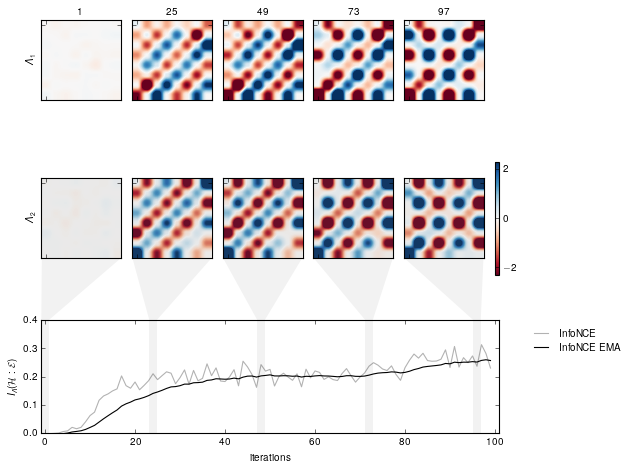

In [6]:
print('RSMI estimate is ', cg_opt.RSMI_estimate(estimates, ema_span=20))

plotter.plot_fancy_rsmimax(estimates, filters, opt_params, CG_params, 
                            generator, mi_bound=r'$\rm InfoNCE$', 
                            filter_lim=2.3, EMA_span=20, save=False, 
                            series_skip=opt_params['iterations']//4-1, 
                            interpolation='hanning', cmap='RdBu')

print(CG_params)
print(critic_params)
print(opt_params)